In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
import dlib

In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=2b4a346d8163348ea219d2485f13280b79313f15cd62d13e11536e690ee74b61
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [3]:
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb

In [4]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/driver_drowsiness_detection_modified.zip
!unzip -qo driver_drowsiness_detection_modified.zip

--2022-12-06 19:04:32--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/driver_drowsiness_detection_modified.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.67
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127436131 (122M) [application/x-zip-compressed]
Saving to: ‘driver_drowsiness_detection_modified.zip’

driver_drowsiness_d 100%[===================>] 121.53M  12.2MB/s    in 12s     

2022-12-06 19:04:44 (10.5 MB/s) - ‘driver_drowsiness_detection_modified.zip’ saved [127436131/127436131]



In [5]:
data = np.load('driver_drowsiness_detection/dataset_compressed.npz', allow_pickle=True)
X = data['arr_0']
Y = data['arr_1']

X = list(X)
Y = list(Y)
print(len(X))
print(len(Y))

1452
1452


In [6]:
for i in range(len(X)):
    img = X[i]
    img = cv2.resize(img, (32, 32))
    X[i] = img
    
print(len(X))
print(X[0].shape)

1452
(32, 32, 3)


In [7]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)
print(Y.shape)
print(Y[0])
print(set(Y))

(1452,)
0
{0, 1}


In [8]:
X = np.array(X)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

(1452, 32, 32, 3)
(1452,)


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1161, 32, 32, 3)
(1161,)
(291, 32, 32, 3)
(291,)
(1161, 32, 32, 3)
(1161, 2)
(291, 32, 32, 3)
(291, 2)


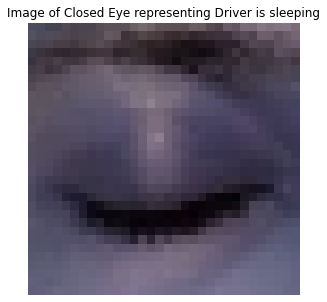

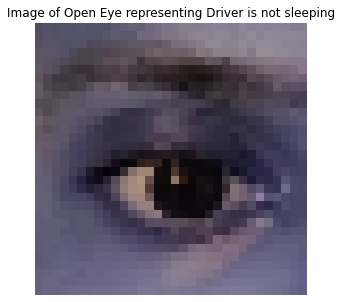

In [11]:
figure1 = plt.figure(figsize=(5, 5))
idx_closed = np.where(Y==0)
img_closed = X[idx_closed[0][0]]
plt.imshow(img_closed)
plt.title('Image of Closed Eye representing Driver is sleeping')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_open = np.where(Y==1)
img_open = X[idx_open[0][0]]
plt.imshow(img_open)
plt.title('Image of Open Eye representing Driver is not sleeping')
plt.axis('off')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


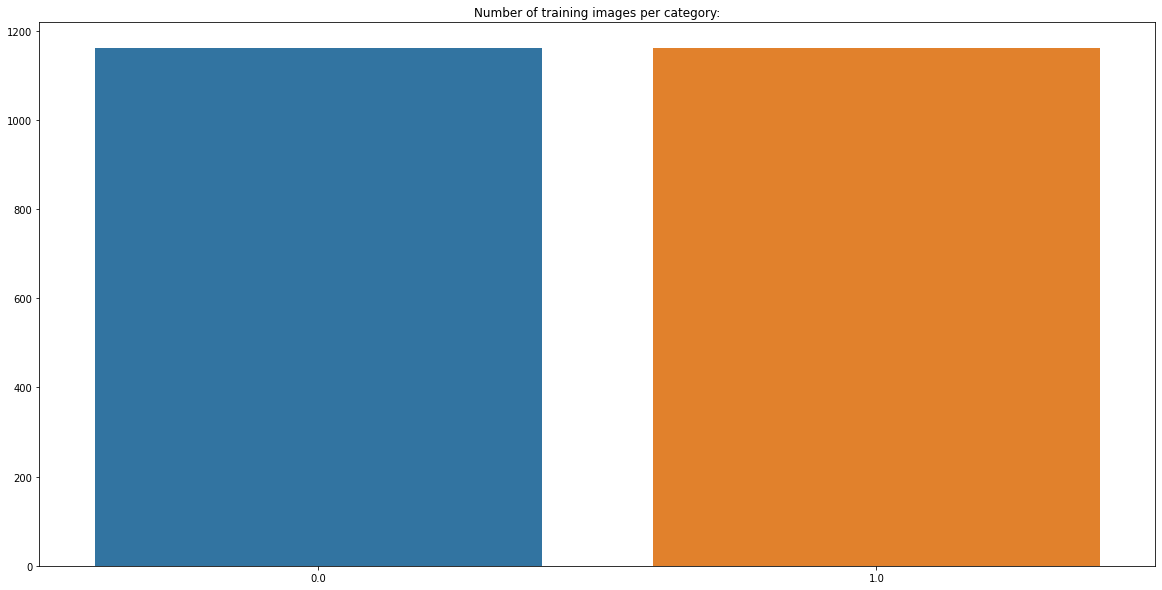

In [12]:
unique_train, count = np.unique(Y_train, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_train, count).set_title("Number of training images per category:")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


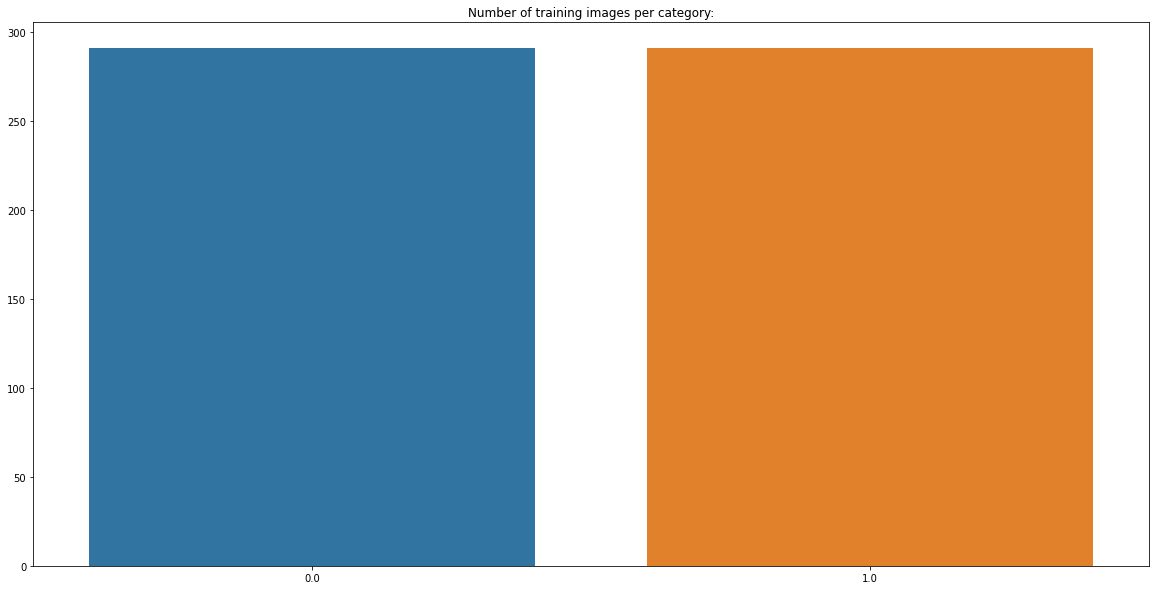

In [13]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
plt.figure(figsize=(20, 10))
sns.barplot(unique_test, count_test).set_title("Number of training images per category:")
plt.show()

In [14]:
def driver_drowsiness_detection_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv5', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv6', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), name='conv7', activation='relu', 
                     kernel_initializer=glorot_uniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam(0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
model= driver_drowsiness_detection_model(input_shape=(32, 32, 3))
model.summary()

2022-12-06 19:04:49.723767: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        1

In [16]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=200, validation_data=(X_test, Y_test))

2022-12-06 19:04:50.327295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
10/10 [==============================] - 5s 298ms/step - loss: 1.3745 - accuracy: 0.5030 - val_loss: 0.7206 - val_accuracy: 0.5017
Epoch 2/200
10/10 [==============================] - 3s 250ms/step - loss: 1.1476 - accuracy: 0.5607 - val_loss: 0.7172 - val_accuracy: 0.4948
Epoch 3/200
10/10 [==============================] - 3s 268ms/step - loss: 1.0443 - accuracy: 0.5607 - val_loss: 0.6788 - val_accuracy: 0.5258
Epoch 4/200
10/10 [==============================] - 3s 310ms/step - loss: 0.9232 - accuracy: 0.5797 - val_loss: 0.6449 - val_accuracy: 0.5670
Epoch 5/200
10/10 [==============================] - 3s 262ms/step - loss: 0.9119 - accuracy: 0.5952 - val_loss: 0.6243 - val_accuracy: 0.6529
Epoch 6/200
10/10 [==============================] - 3s 262ms/step - loss: 0.7858 - accuracy: 0.6296 - val_loss: 0.6097 - val_accuracy: 0.7045
Epoch 7/200
10/10 [==============================] - 3s 332ms/step - loss: 0.8258 - accuracy: 0.6176 - val_loss: 0.5966 - val_accuracy: 0.7388

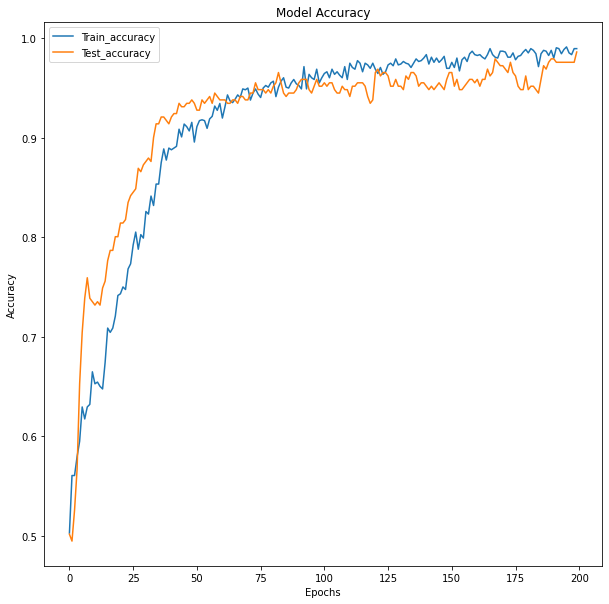

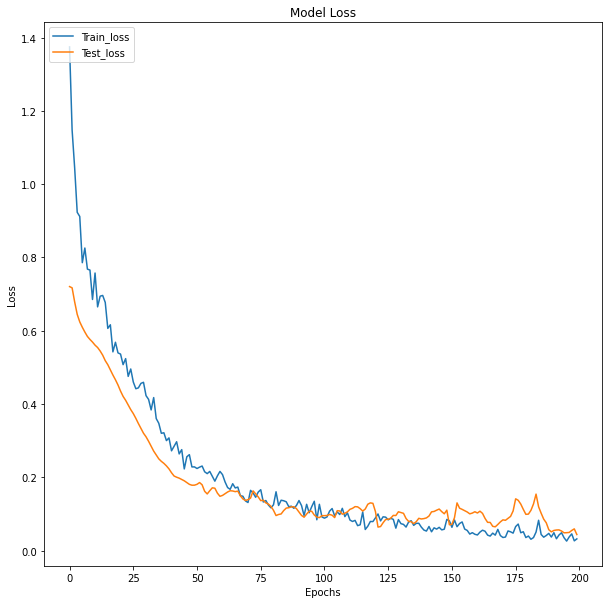

In [17]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [18]:
pred = model.evaluate(X_test, Y_test)
print(f'Test Set Accuracy: {pred[1]}')
print(f'Test Set Loss: {pred[0]}')

10/10 [==============================] - 0s 21ms/step - loss: 0.0442 - accuracy: 0.9863
Test Set Accuracy: 0.9862542748451233
Test Set Loss: 0.04419432953000069


In [19]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_pred = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       145
           1       0.99      0.98      0.99       146

    accuracy                           0.99       291
   macro avg       0.99      0.99      0.99       291
weighted avg       0.99      0.99      0.99       291



<AxesSubplot:>

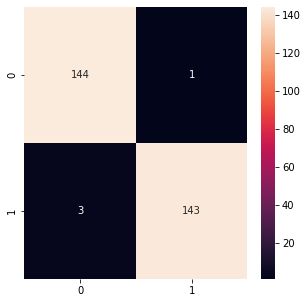

In [20]:
matrix = confusion_matrix(Y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [21]:
model.save('Driver_Drowsiness_Detection.h5')

In [22]:
labels = ['Closed', 'Open']
img_closed1 = cv2.imread('driver_drowsiness_detection/closed_eye.jpg')
img_closed2 = cv2.imread('driver_drowsiness_detection/closed_eye2.jpg')
img_open1 = cv2.imread('driver_drowsiness_detection/open_eye.jpg')
img_open2 = cv2.imread('driver_drowsiness_detection/open_eye2.jpg')

img_closed1 = cv2.resize(img_closed1, (32, 32))
img_closed2 = cv2.resize(img_closed2, (32, 32))
img_open1 = cv2.resize(img_open1, (32, 32))
img_open2 = cv2.resize(img_open2, (32, 32))

img_closed1 = np.array(img_closed1)
img_closed2 = np.array(img_closed2)
img_open1 = np.array(img_open1)
img_open2 = np.array(img_open2)

img_closed1 = np.expand_dims(img_closed1, axis=0)
img_closed2 = np.expand_dims(img_closed2, axis=0)
img_open1 = np.expand_dims(img_open1, axis=0)
img_open2 = np.expand_dims(img_open2, axis=0)

In [23]:
ypred_closed1 = model.predict(img_closed1)
ypred_closed2 = model.predict(img_closed2)
ypred_open1 = model.predict(img_open1)
ypred_open2 = model.predict(img_open2)

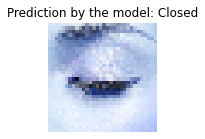

In [24]:
figure = plt.figure(figsize=(2, 2))
img_closed1 = np.squeeze(img_closed1, axis=0)
plt.imshow(img_closed1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed1[0], axis=0)]}')
plt.show()

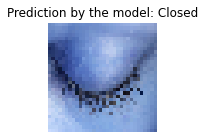

In [25]:
figure = plt.figure(figsize=(2, 2))
img_closed2 = np.squeeze(img_closed2, axis=0)
plt.imshow(img_closed2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_closed2[0], axis=0)]}')
plt.show()

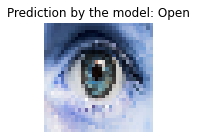

In [26]:
figure = plt.figure(figsize=(2, 2))
img_open1 = np.squeeze(img_open1, axis=0)
plt.imshow(img_open1)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open1[0], axis=0)]}')
plt.show()

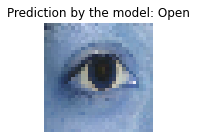

In [27]:
figure = plt.figure(figsize=(2, 2))
img_open2 = np.squeeze(img_open2, axis=0)
plt.imshow(img_open2)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_open2[0], axis=0)]}')
plt.show()